# Radar Gesture Detection Project

# Section: Exploratory Data Analysis (EDA)

In [1]:
# Import necessary libraries
import os  
import numpy as np  
import matplotlib.pyplot as plt
from scipy.fft import fft
import scipy.signal.windows as windows
from scipy.signal import find_peaks
import matplotlib.animation as animation
from functools import partial
import matplotlib.animation as animation

### Load One Data Instance per Gesture

In [2]:
# Define constants for data folder and example file names (data instances)
DATA_FOLDER = './fulldata'
INSTANCE_FILES = {
    'push': 'Push_e1_u1_s1.npy',
    'swipe_up': 'SwipeUp_e1_u1_s1.npy',
    'swipe_down': 'SwipeDown_e1_u1_s1.npy',
    'swipe_left': 'SwipeLeft_e1_u1_s1.npy',
    'swipe_right': 'SwipeRight_e1_u1_s1.npy'
}

# Construct the full paths using dictionary comprehension
instance_paths = {action: os.path.join(DATA_FOLDER, file_name) for action, file_name in INSTANCE_FILES.items()}

# Load the data instances dynamically into a dictionary
data_instances = {action: np.load(path) for action, path in instance_paths.items()}

push_data = data_instances['push']
swipe_up_data = data_instances['swipe_up']
swipe_down_data = data_instances['swipe_down']
swipe_left_data = data_instances['swipe_left']
swipe_right_data = data_instances['swipe_right']


In [3]:
# Unpack and display the shape of the loaded data by using one of the data instances
num_frames, num_antennas, num_chirps, num_samples = swipe_up_data.shape

print(f"Data Dimensions:\n"
      f"- Number of frames: {num_frames}\n"
      f"- Number of antennas: {num_antennas}\n"
      f"- Number of chirps: {num_chirps}\n"
      f"- Number of samples: {num_samples}")

Data Dimensions:
- Number of frames: 100
- Number of antennas: 3
- Number of chirps: 32
- Number of samples: 64


**Comment**
- **Number of frames**: There are 100 separate data frames, each representing a snapshot of the data.
- **Number of antennas**: The data comes from 3 antennas, each capturing a signal.
- **Number of chirps**: Each frame contains 32 chirps, or radar signals.
- **Number of samples**: Each chirp is measured at 64 different points in time, giving 64 samples per chirp.


## Preprocessing and Visualization of Radar Data Instances

#### Visualization of Radar Signals for the First Antenna and First Chirp Across 100 Frames

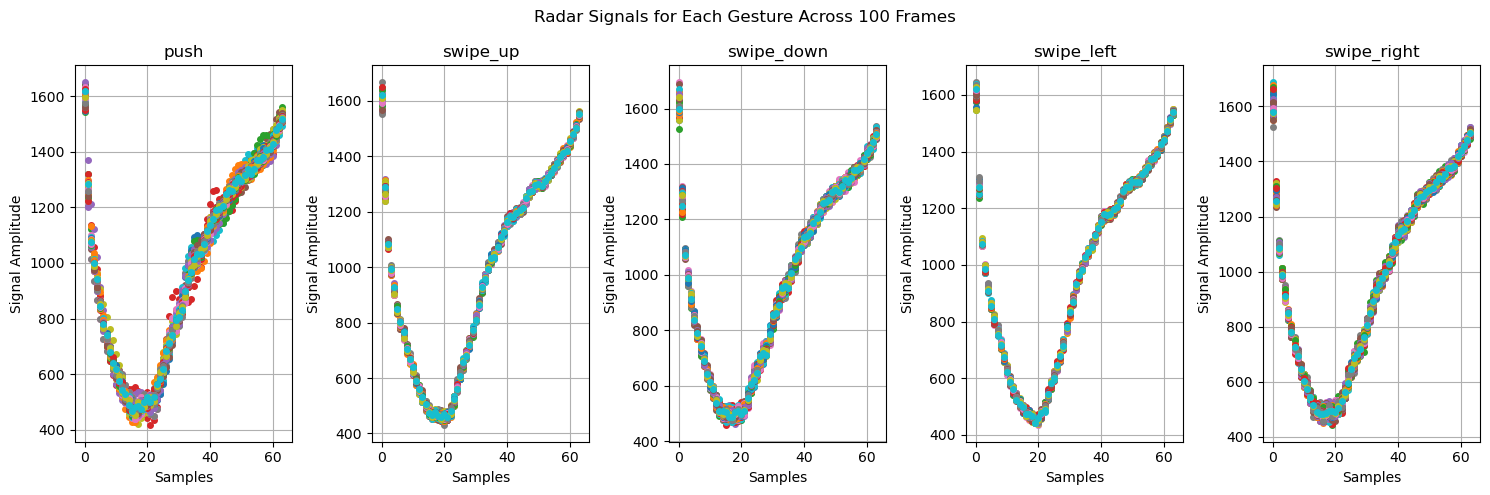

In [4]:
# Create subplots
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
ax = ax.flatten()

# Plot data for each instance
for i, (action,data) in enumerate(data_instances.items()):
    for frame in range(num_frames):
        ax[i].plot(data[frame, 0, 0, :], 'o', markersize=4)  # Customize marker size if needed
    ax[i].set_title(action)
    ax[i].set_xlabel("Samples")
    ax[i].set_ylabel("Signal Amplitude")
    ax[i].grid(True)  # Optionally add grid for better readability
plt.suptitle("Radar Signals for Each Gesture Across 100 Frames")
plt.tight_layout()
plt.show()


### **Comment**

The visualization above represents radar measurements for each hand gesture. The reference paper [here](https://arxiv.org/pdf/2310.08876) applies preprocessing to detect the hand as a moving target. We begin by transforming the raw radar data into range profiles using fast time processing, followed by a peak search on the data. Let's explore these steps one by one and examine how they affect the signals.

These steps include:

1. **Remove bias** from the sample axis by subtracting its mean.
2. **Apply windowing** before performing the Fourier Transform (FFT).
3. **Perform FFT** to convert the data into the frequency domain,  **Remove the complex mean** by subtracting the mean across the chirps, **Drop the symmetric part** of the spectrum and adjust the magnitude by multiplying by 2.
4. **Integrate the data** across chirps and antennas.

The resulting spectrum will provide the range profiles for each gesture, showing signal magnitude versus radial distance.


### Step 1: Remove Bias

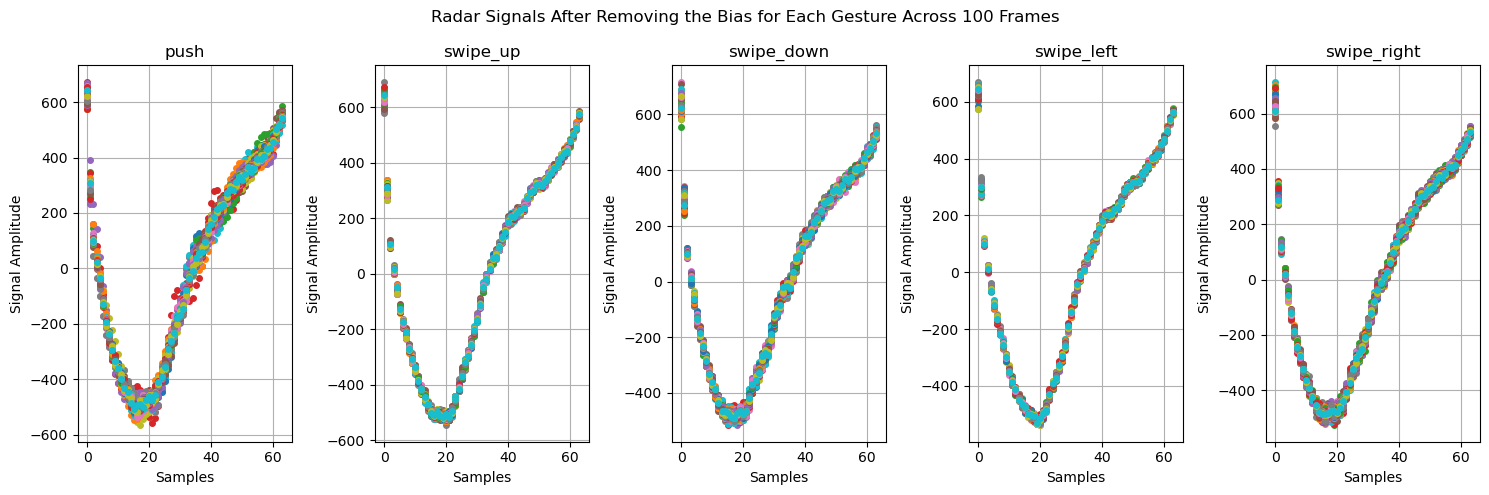

In [5]:
# Create subplots
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
ax = ax.flatten()

# Process and plot each instance
for i, (action, data) in enumerate(data_instances.items()):
    # Remove DC component: subtract mean along the sample axis (axis=-1)
    data_dc_removed = data - np.mean(data, axis=-1, keepdims=True)
    
    # Plot the data for each frame
    for frame in range(num_frames):
        ax[i].plot(data_dc_removed[frame, 0, 0, :], 'o', markersize=4) 

    # Set titles, labels, and grid
    ax[i].set_title(action)
    ax[i].set_xlabel("Samples")
    ax[i].set_ylabel("Signal Amplitude")
    ax[i].grid(True)  
plt.suptitle("Radar Signals After Removing the Bias for Each Gesture Across 100 Frames")
# Adjust layout
plt.tight_layout()
plt.show()


**Comment**

After removing the sample bias, the signal amplitude range changed: it was between 400 and 1600 previously, and is now between -600 and 600.

### Step 2: Apply Windowing

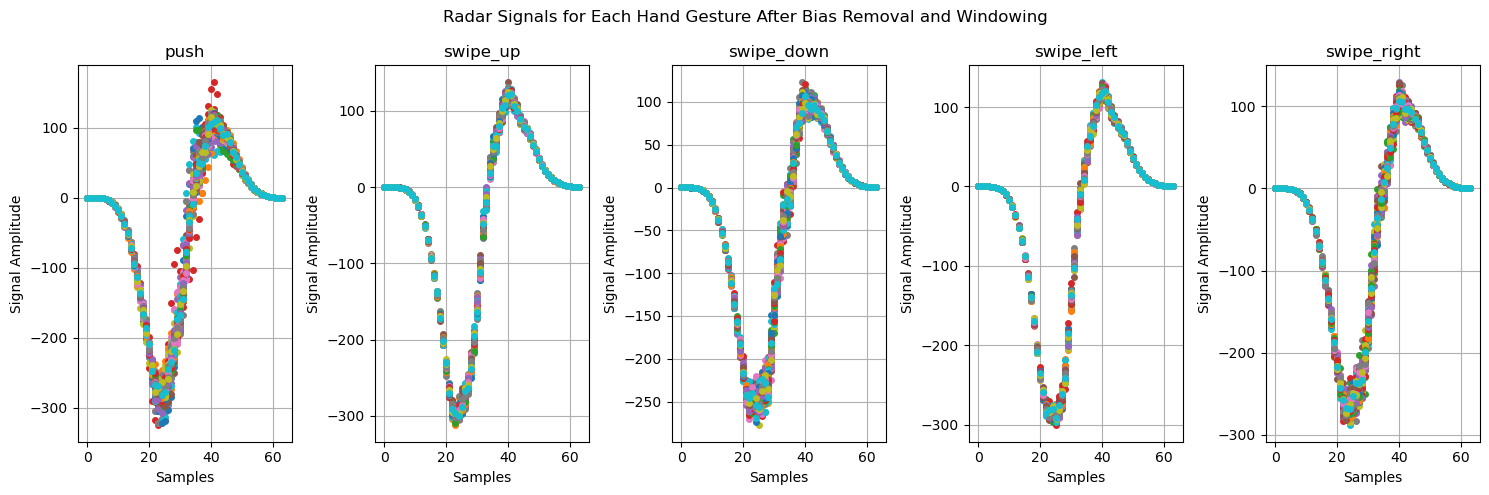

In [6]:
# Create the Blackman-Harris window
range_window = windows.blackmanharris(num_samples).reshape(1, num_samples)

# Create subplots
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
ax = ax.flatten()

# Process and plot each instance
for i, (action, data) in enumerate(data_instances.items()):
    # Remove DC component: subtract mean along the sample axis (axis=-1)
    data_dc_removed = data - np.mean(data, axis=-1, keepdims=True)
    
    # Apply windowing (Blackman-Harris)
    data_dc_removed_windowed = data_dc_removed * range_window
    
    # Plot the data for each frame
    for frame in range(num_frames):
        ax[i].plot(data_dc_removed_windowed[frame, 0, 0, :], 'o', markersize=4) 

    # Set titles, labels, and grid
    ax[i].set_title(action)
    ax[i].set_xlabel("Samples")
    ax[i].set_ylabel("Signal Amplitude")
    ax[i].grid(True) 
plt.suptitle("Radar Signals for Each Hand Gesture After Bias Removal and Windowing")

# Adjust layout
plt.tight_layout()
plt.show()


**Comment**

Windowing altered the signal amplitude and shaped the signal to eliminate abrupt discontinuities.


### Step 3: Get Range Profiles

1. **Apply FFT**: Perform the Fast Fourier Transform (FFT) on the data to extract frequency-domain information.

2. **Remove Complex Mean**: Subtract the complex mean over the slow-time axis (chirp axis) to eliminate (quasi-)static targets.

3. **Adjust Spectrum**: 
   - Drop the symmetric part of the spectrum to focus on relevant frequencies.
   - Adjust the amplitude for proper scaling.

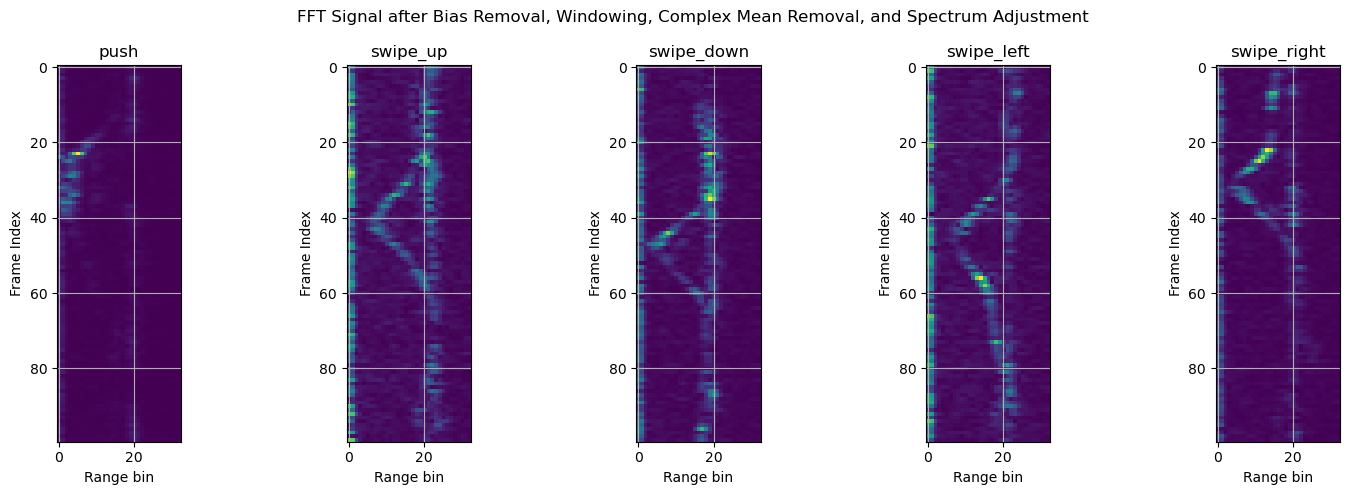

In [7]:
# Create subplots
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
ax = ax.flatten()

# Process and plot each instance
for i, (action,data) in enumerate(data_instances.items()):
    # Step 1: Remove DC component: subtract mean along the sample axis (axis=-1)
    data_dc_removed = data - np.mean(data, axis=-1, keepdims=True)
    
    # Step 2: Apply windowing (Blackman-Harris)
    data_dc_removed_windowed = data_dc_removed * range_window
    
    # Step 3: Apply FFT
    fft_data = np.fft.fft(data_dc_removed_windowed, axis=-1) / np.sum(range_window)  # Normalize by window
    
    # Step 4: Remove the complex mean (mean across the chirps)
    fft_data_complex_mean_removed = fft_data - np.mean(fft_data, axis=2)[..., np.newaxis, :]
    
    # Step 5: Drop the symmetric part of the spectrum
    fft_data_complex_mean_removed = fft_data_complex_mean_removed[...,:num_samples//2 + 1]
    
    # Step 6: Adjust the amplitude for the negative frequencies
    fft_data_complex_mean_removed[:,:,:,1::-1] = 2 * fft_data_complex_mean_removed[:,:,:,1::-1]
    
    # Plot the adjusted FFT results for each frame (using only the positive frequencies)
    #for frame in range(num_frames):
       # ax[i].plot(np.abs(fft_data_complex_mean_removed[frame, 0, 0, :]), markersize=4)  # Plot magnitude of FFT
    ax[i].imshow(np.abs(fft_data_complex_mean_removed[:, 0, 0, :])) 
        
    # Set titles, labels, and grid
    ax[i].set_title(action)
    ax[i].set_xlabel("Range bin")
    ax[i].set_ylabel("Frame Index")
    ax[i].grid(True) 

plt.suptitle("FFT Signal after Bias Removal, Windowing, Complex Mean Removal, and Spectrum Adjustment")
# Adjust layout
plt.tight_layout()
plt.show()


**Comment**

The plots above shows the hand movements. Each row represent a frame. As time progresses, the hand moves closer to the radar, reaches a peak proximity, and then moves away.

### Step 4: Integrate the Signal Across Antennas and Chirps to get a stronger signal

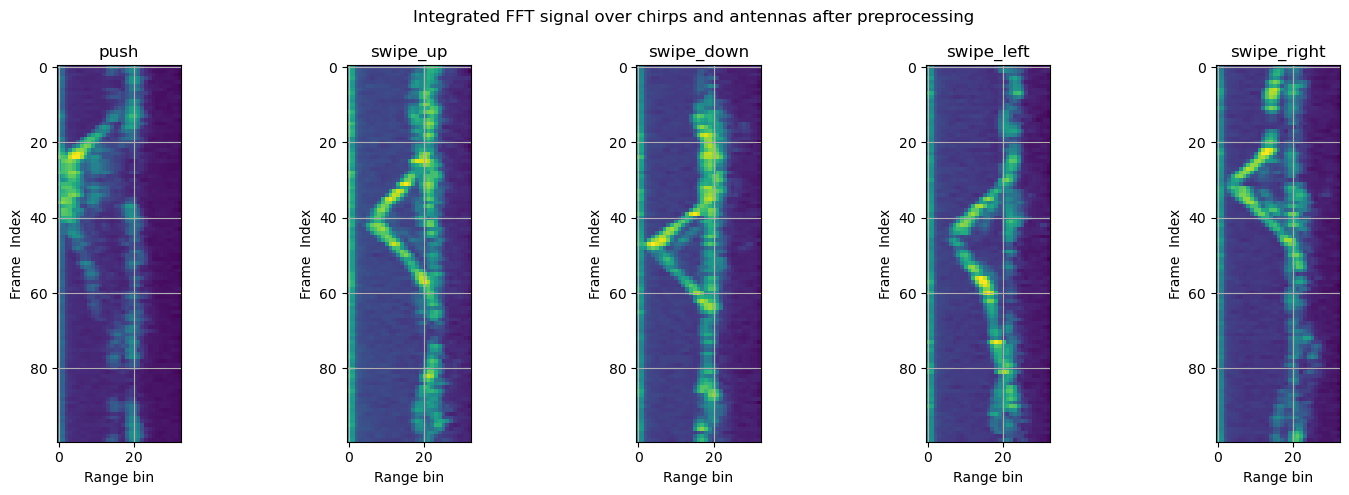

In [8]:
# Create subplots for plotting
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
ax = ax.flatten()

# Process and plot each instance
for i, (action, data) in enumerate(data_instances.items()):
    # Step 1: Remove DC component: subtract mean along the sample axis (axis=-1)
    data_dc_removed = data - np.mean(data, axis=-1, keepdims=True)
    
    # Step 2: Apply windowing (Blackman-Harris)
    data_dc_removed_windowed = data_dc_removed * range_window
    
    # Step 3: Apply FFT
    fft_data = np.fft.fft(data_dc_removed_windowed, axis=-1) / np.sum(range_window)  # Normalize by window
    
    # Step 4: Remove the complex mean (mean across the frequency bins)
    fft_data_complex_mean_removed = fft_data - np.mean(fft_data, axis=2)[..., np.newaxis, :]
    
    # Step 5: Drop the symmetric part of the spectrum
    fft_data_complex_mean_removed = fft_data_complex_mean_removed[...,:num_samples//2 + 1]
    
    # Step 6: Adjust the amplitude for the negative frequencies
    fft_data_complex_mean_removed[:,:,:,1::-1] = 2 * fft_data_complex_mean_removed[:,:,:,1::-1]
    
    # Step 7: Integrate the absolute FFT data across antennas and chirps
    integrated_data = np.sum(np.abs(fft_data_complex_mean_removed), axis=(1, 2)) / (num_antennas * num_chirps)
    
    # Plot the integrated data
    ax[i].imshow(np.log10(integrated_data)) # Take log to see the low signals
    
    # Set titles, labels, and grid
    ax[i].set_title(action)
    ax[i].set_xlabel("Range bin")
    ax[i].set_ylabel("Frame  Index")
    ax[i].grid(True)
plt.suptitle("Integrated FFT signal over chirps and antennas after preprocessing")
plt.tight_layout()
plt.show()


**Comment**

To improve signal quality, we combined data across antennas and chirps.

The plots visualize the hand's trajectory over 100 frames. Each frame shows the hand moving closer to the radar, reaching its closest point, and then moving away. The intensity of the signal is represented by color.

**Note:** According to the reference paper, each gesture recording consists of 100 frames (a total of 3 seconds), with the actual gesture execution lasting approximately 0.3 seconds, or about 10 frames. Therefore, we need to identify these 10 relevant frames within the sequence.


### Visualizing a Single Frame's Range Profile

Let's examine a single frame from the integrated data to visualize a range profile, similar to the ones presented in the paper.

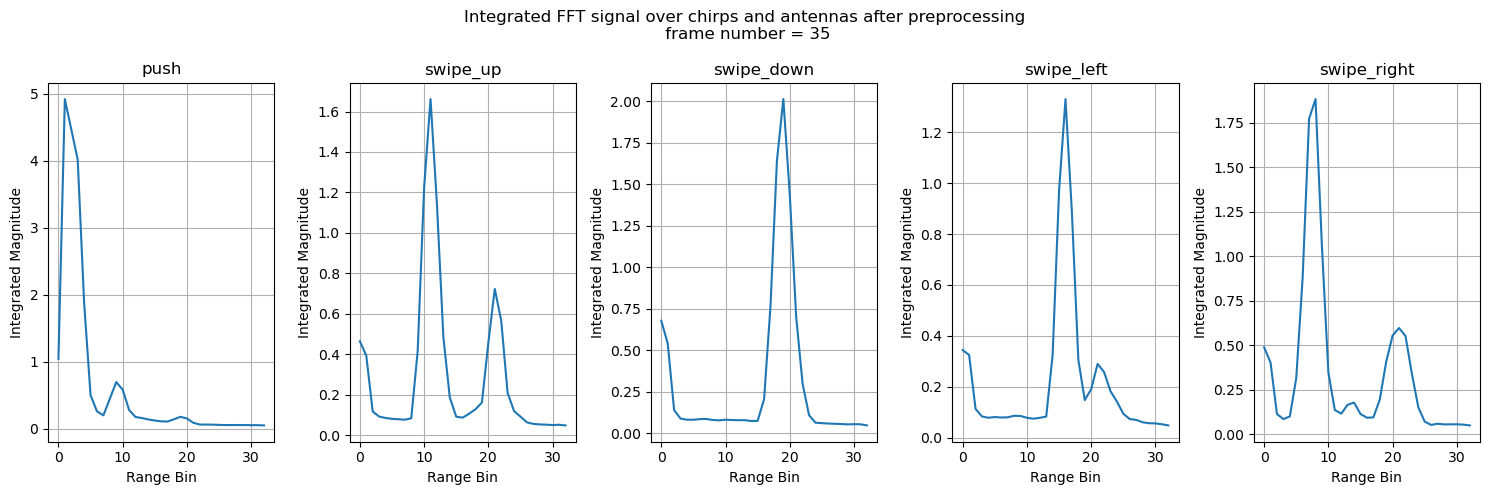

In [9]:
range_window = windows.blackmanharris(num_samples).reshape(1, num_samples)
range_instances = {}
# Create subplots for plotting
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
ax = ax.flatten()
frame_idx = 35


# Process and plot each instance
for i, (name, data) in enumerate(data_instances.items()):
    # Step 1: Remove DC component: subtract mean along the sample axis (axis=-1)
    data_dc_removed = data - np.mean(data, axis=-1, keepdims=True)
    
    # Step 2: Apply windowing (Blackman-Harris)
    data_dc_removed_windowed = data_dc_removed * range_window
    
    # Step 3: Apply FFT
    fft_data = np.fft.fft(data_dc_removed_windowed, axis=-1) / num_samples  # Normalize by num_samples
    
    # Step 4: Remove the complex mean (mean across the frequency bins)
    fft_data_complex_mean_removed = fft_data - np.mean(fft_data, axis=2)[..., np.newaxis, :]
    
    # Step 5: Drop the symmetric part of the spectrum
    fft_data_complex_mean_removed = fft_data_complex_mean_removed[...,:num_samples//2 + 1]
    
    # Step 6: Adjust the amplitude for the negative frequencies
    fft_data_complex_mean_removed[:,:,:,1::-1] = 2 * fft_data_complex_mean_removed[:,:,:,1::-1]
    
    # Step 7: Integrate the absolute FFT data across antennas and chirps
    integrated_data = np.sum(np.abs(fft_data_complex_mean_removed), axis=(1, 2)) / (num_antennas * num_chirps)
    range_instances[name] = integrated_data
    # Plot the integrated data
    ax[i].plot(integrated_data[frame_idx]) # Take log to see the low signals
    
    # Set titles, labels, and grid
    ax[i].set_title(name)
    ax[i].set_xlabel("Range Bin")
    ax[i].set_ylabel("Integrated Magnitude")
    ax[i].grid(True)
plt.suptitle(f"Integrated FFT signal over chirps and antennas after preprocessing\n frame number = {frame_idx}")
plt.tight_layout()
plt.show()


**Comment**

As outlined in the reference paper, the range profile highlights two target signals: the moving hand and the person's body. The signal closer to the radar corresponds to the hand. Depending on the selected frame, a single signal may appear, representing either a combined signal from the hand and body or just one of them individually. The event observed here shows that as the hand moves closer to the radar during the gesture, its range (distance from the radar) shifts toward 0, indicating increased proximity.


### Detect Hand signals and Visualize it

In [10]:
# Detect the range bin at the maximum signal for each frame 
range_bins = {}
n_skip = 3
for gesture_name, range_profile in range_instances.items():
    indexes = np.argmax(range_profile[:, n_skip:], axis=1) # finds idx of maximum peak for each frame after skipping a few points (noise) in the sample dimension
    range_bins[gesture_name] = indexes + n_skip
    

In [11]:
print("Range bins at maximum signal for each frame for the selected gestures:\n")
range_bins

Range bins at maximum signal for each frame for the selected gestures:



{'push': array([20, 19, 20, 20, 20, 20, 20, 19, 19, 20, 20, 20, 20, 19, 19, 19, 19,
        12, 10,  8,  8,  7,  6,  5,  4,  3,  3,  3,  4,  3,  4,  3,  3,  4,
         4,  3,  3,  3,  3,  3,  3,  3,  4,  3,  4,  4,  5,  6,  5, 20, 21,
        19,  7,  7,  8,  9, 21, 20,  9,  9, 20, 20, 20,  9, 21, 20, 19, 20,
        20, 19, 19, 16, 19, 19, 20, 19, 19, 19, 14, 20, 20, 17,  3, 19,  3,
         3, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20]),
 'swipe_up': array([21, 21, 21, 21, 21, 21, 22, 20, 20, 21, 20, 22, 22, 22, 21, 21, 21,
        21, 21, 21, 21, 20, 19, 20, 20, 18, 20, 22, 22, 16, 16, 15, 21, 13,
        12, 11, 10,  9,  9,  8,  8, 21,  8,  9,  9, 10, 11, 12, 13, 14, 15,
        15, 16, 17, 18, 19, 19, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23,
        24, 23, 19,  3, 23, 22, 23, 23, 22, 22, 22, 22, 21, 21, 21, 21, 21,
        20, 22, 20, 22, 21, 22, 18, 23, 23, 24, 23, 19, 22, 21, 21]),
 'swipe_down': array([19, 17, 16, 20, 17, 19, 16, 19, 19, 19, 16, 16, 19, 16, 16

<Figure size 640x480 with 0 Axes>

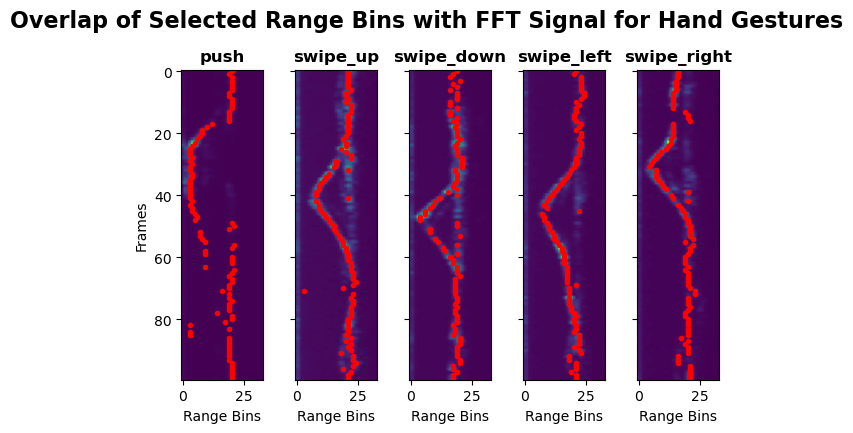

In [12]:
plt.figure() 
fig, ax = plt.subplots(1, 5, sharey=True)
ax = ax.flatten()

# Iterate through each gesture and its corresponding data
for i, (gesture_name, data) in enumerate(range_instances.items()):
    ax[i].imshow(data, aspect='auto', cmap='viridis')  # Use a colormap for better visualization
    ax[i].plot(range_bins[gesture_name], np.arange(len(data)), 'r.')
    ax[i].set_xlabel("Range Bins", fontsize=10)
    ax[i].set_title(gesture_name, fontsize=12, fontweight='bold')
    if i==0:
        ax[i].set_ylabel("Frames", fontsize=10)

plt.suptitle("Overlap of Selected Range Bins with FFT Signal for Hand Gestures", 
             fontsize=16, fontweight='bold', y=0.92)
plt.tight_layout(pad=2) 
plt.show();


**Comment**  
The above plot demonstrates that the selected range bins (represented by red dots) align perfectly with the overall movement of the hand across the 100 frames, effectively capturing the hand signals.


## Generating Range-Doppler Images (RDI)

The process of generating Range-Doppler Images (RDI) involves applying FFT (Fast Fourier Transform) along both the slow axis (chirp axis) and the fast axis (sample axis). The resulting RDI displays the following:

- **X-axis**: Represents the Doppler frequency (or velocity).
- **Y-axis**: Represents the range (distance).

#### Steps to Generate Range-Doppler Images:

1. **Remove Bias**: Remove any bias along the sample axis.
2. **Apply Windowing**: Apply a window function to reduce spectral leakage along the sample axis.
3. **Apply FFT**: Perform FFT along the sample axis.
4. **Remove the Complex Mean**: Eliminate the complex mean over the slow time axis (chirp axis) to remove (quasi-)static targets.
5. **Drop the Symmetric Part**: Remove the symmetric part of the spectrum and adjust the amplitude.  
   These steps result in the `range_fft` data.
6. **Windowing on Chirp Axis**: Apply windowing to the data along the chirp axis.
7. **Apply FFT on Chirp Axis**: Perform FFT along the chirp axis, followed by an FFT shift to center the frequency.
8. **Integrate the Signal** across antennas.


In [13]:
range_window = windows.blackmanharris(num_samples).reshape(1, num_samples)
doppler_window = windows.blackmanharris(num_chirps).reshape(1, 1, num_chirps, 1)
range_doppler_instances = {}

for name, data in data_instances.items() :
    # Step 1: Remove DC component: subtract mean along the sample axis (axis=-1)
    data_dc_removed = data - np.mean(data, axis=-1, keepdims=True)
    
    # Step 2: Apply windowing (Blackman-Harris) to sample axis
    data_dc_removed_windowed = data_dc_removed * range_window
    
    # Step 3: Apply FFT
    fft_data = np.fft.fft(data_dc_removed_windowed, axis=-1) / np.sum(range_window)  # Normalize by window
    
    # Step 4: Remove the complex mean (mean across the chirps)
    fft_data_complex_mean_removed = fft_data - np.mean(fft_data, axis=2)[..., np.newaxis, :]
    
    # Step 5: Drop the symmetric part of the spectrum
    fft_data_complex_mean_removed = fft_data_complex_mean_removed[...,:num_samples//2 + 1]
    fft_data_complex_mean_removed[:,:,:,1::-1] = 2*fft_data_complex_mean_removed [:,:,:,1::-1]

    # Step 6: Apply windowing (Blackman-Harris) to chirp axis
    fft_data_complex_mean_removed_windowed = fft_data_complex_mean_removed * doppler_window

    # Step 7: Apply FFT on Chirp Axis
    range_doppler = np.fft.fftshift(np.fft.fft(fft_data_complex_mean_removed_windowed, axis=2), axes=2)/np.sum(doppler_window)
    
    # Step 8: Integrate the absolute FFT data across antennas 
    integrated_data = np.sum(np.abs(range_doppler), axis=1) / num_antennas

    # save data
    range_doppler_instances[name]=integrated_data


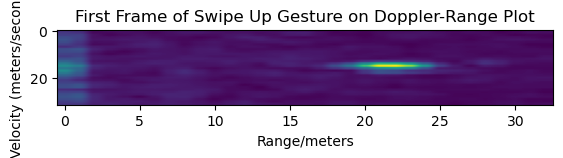

In [14]:
plt.figure()
plt.imshow(range_doppler_instances['swipe_up'][0,:,:], aspect=5/32) 
plt.xlabel("Range/meters")
plt.ylabel("Velocity (meters/seconds)")
plt.title("First Frame of Swipe Up Gesture on Doppler-Range Plot");

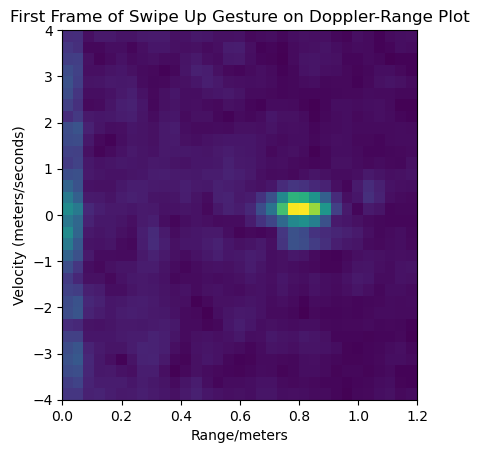

In [15]:
plt.figure()
plt.imshow(range_doppler_instances['swipe_up'][0,:,:], extent=[0,1.2,-4,4], aspect=5/32) 
plt.xlabel("Range/meters")
plt.ylabel("Velocity (meters/seconds)")
plt.title("First Frame of Swipe Up Gesture on Doppler-Range Plot");

### Developing a Function to Detect Hand Gestures Using Range-Doppler Images"

In [16]:
def create_range_doppler_animation(range_doppler_map: np.ndarray, filename: str = "test.html"):
    if range_doppler_map.ndim == 4:
        rdm = range_doppler_map[:,0, :, :]
    else:
        rdm = range_doppler_map

    fig, ax = plt.subplots()
    im = ax.imshow(np.abs(rdm[0]), extent=[0,1.2,-4,4], aspect=5/32)
    ax.set_xlabel("Range / meters")
    ax.set_ylabel("Doppler Velocity (meters/seconds)")
    ax.set_title("Visualization of Hand Gesture Dynamics Across 100 Frames")

    def update(frame, rdm=rdm):
        im.set_data(np.abs(rdm[frame]))
    
        return im

    ani = animation.FuncAnimation(fig=fig, func=partial(update, rdm=rdm), frames=100, interval=30)
    writer = animation.HTMLWriter(fps=30, codec=None, bitrate=None, extra_args=None, metadata=None, embed_frames=True, default_mode='loop', embed_limit=None)
    ani.save(filename, writer=writer)
    plt.show()
    return fig, ax, ani

#### Visualisation of Swipe up Gesture

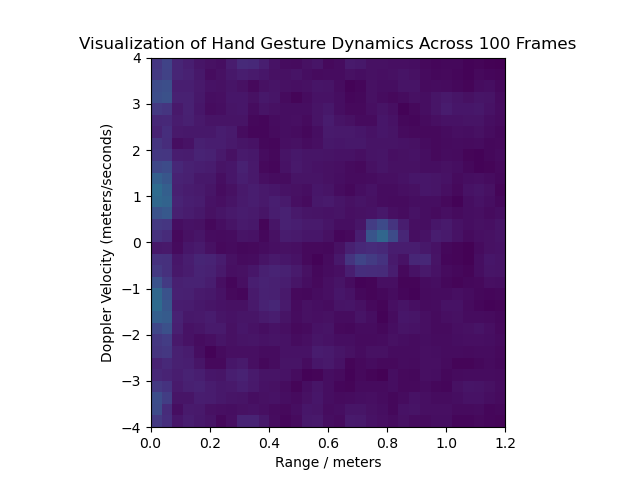

In [17]:
%matplotlib widget
a=create_range_doppler_animation(range_doppler_instances['swipe_up']);

### Animation Overview: Swipe-Up Hand Gesture

This animation depicts a swipe-up hand gesture over **100 frames**:

- The hand starts at the position of approximately **0.9 meters away from the radar**.  
- As the gesture progresses, the **velocity of the movement increases** and hand moves towards the radar.  
- Eventually, the hand moves away from the radar.  

The **color represents the signal intensity**, but the color values were not normalized across frames, as normalization was not the focus of this analysis.

#### Visualisation of Push Gesture

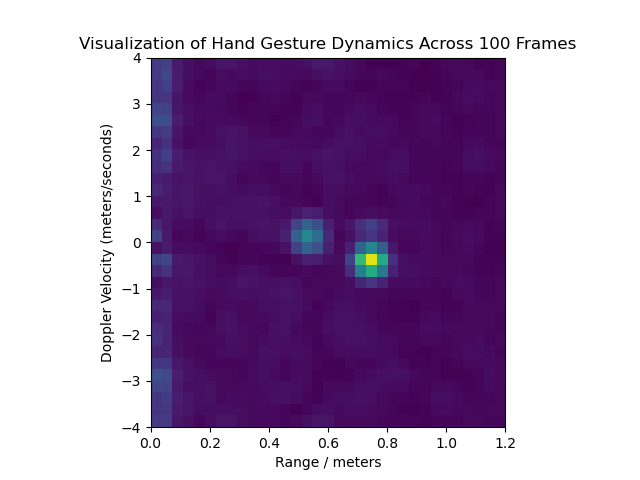

In [31]:
%matplotlib widget
b=create_range_doppler_animation(range_doppler_instances['push']);

### Animation Overview: Push Hand Gesture

The animation illustrates a push hand gesture over **100 frames**:

- The hand begins as a fist approximately **0.8 meters away from the radar**.  
- As the gesture progresses, the **velocity of the movement increases**, with the hand briefly staying very close to the radar.  
- Subsequently, the hand moves away **slowly** from the radar.  

The **color indicates the signal intensity**, but the color values were not normalized across frames, as normalization was not the focus of this analysis.

## Derivation of Range, Radial Velocity, Signal Magnitude, and Horizontal/Vertical Angles

I will demonstrate the above properties using the swipe-up gesture.


### Range (Distance)

In [19]:
# Calculate the range scale, representing the distance (in meters) per range bin
range_bin_resolution = 1.2 / (num_samples // 2 + 1)  # Meters per bin

# Compute the range for a "Swipe Up" gesture by scaling the range bins
range_bins_swipe_up =  range_bins['swipe_up']
swipe_up_range_ = range_bins_swipe_up * range_bin_resolution

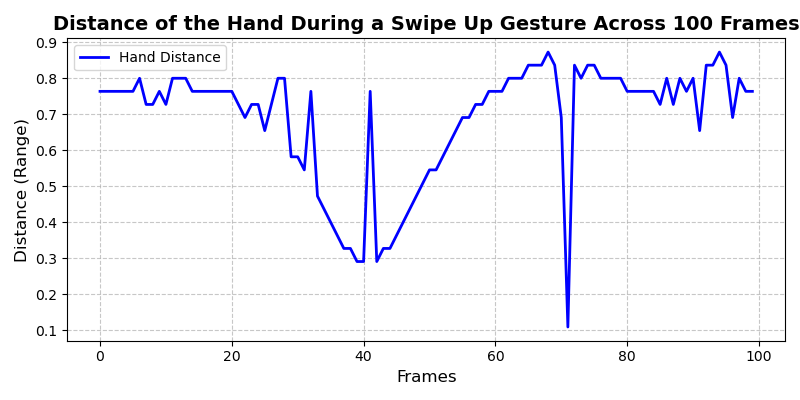

In [20]:
plt.figure(figsize=(8, 4))
plt.plot(swipe_up_range_, color='blue', linewidth=2, label="Hand Distance") 
plt.xlabel("Frames", fontsize=12)
plt.ylabel("Distance (Range)", fontsize=12)
plt.title("Distance of the Hand During a Swipe Up Gesture Across 100 Frames", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)  # Add a grid for better readability
plt.legend(fontsize=10)  
plt.tight_layout() 
plt.show()


### Radial Velocity (doppler)
- In range-Doppler images, the position of the maximum signal corresponds to the **radial velocity**. However, our primary focus is on identifying the **radial velocity of the hand signals**. Doppler images also capture the body and noise, which can interfere with the signal of interest.
- The goal is to determine the **range bin** of the hand signal in the range profile.

Thus, the steps to find the radial velocity of hand signals are:
1. Identify the **range bin** (i.e., the index of the 4th dimension) from the range profiles.
2. Find the **velocity** corresponding to that specific range bin.


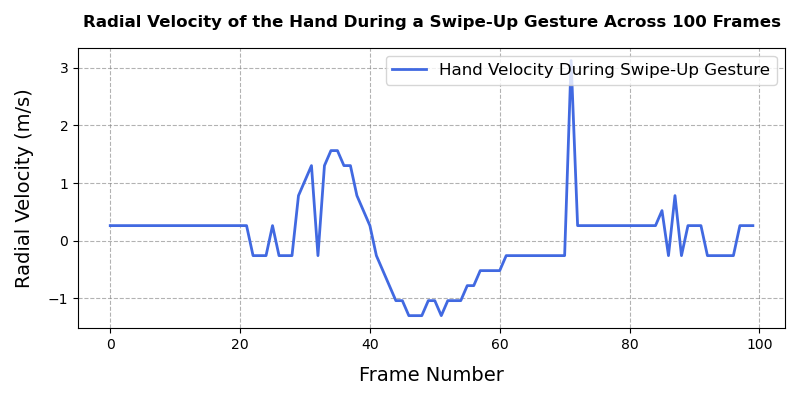

In [21]:
# Calculate Doppler bins and corresponding Doppler values for a swipe up instance
doppler_bins_swipe_up = [
    np.argmax(np.abs(frame[:, i]))  # Find the index of max Doppler shift for each frame
    for i, frame in zip(range_bins['swipe_up'], range_doppler_instances['swipe_up'])
]

# Compute Doppler values based on velocity resolution and the Doppler bins
velocity_resolution = -0.2604  # obtained from reference paper parameters
doppler_values = np.arange(-num_chirps // 2, num_chirps // 2) * velocity_resolution
doppler_swipe_up = doppler_values[doppler_bins_swipe_up]  # Select Doppler values corresponding to max indices

# Plot Doppler velocities
plt.figure(figsize=(8, 4))  
plt.plot(
    doppler_swipe_up, 
    color='royalblue', 
    linewidth=2, 
    label="Hand Velocity During Swipe-Up Gesture"
)

plt.xlabel("Frame Number", fontsize=14, labelpad=10)
plt.ylabel("Radial Velocity (m/s)", fontsize=14, labelpad=10)
plt.title(
    "Radial Velocity of the Hand During a Swipe-Up Gesture Across 100 Frames", 
    fontsize=12, 
    fontweight='bold', 
    pad=15
)
plt.grid(which='both', linestyle='--', color='gray', alpha=0.6)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()


In [22]:
def create_range_doppler_animation_indices(range_doppler_map: np.ndarray, indices: np.ndarray, filename: str = "test.html"):
    if range_doppler_map.ndim == 4:
        rdm = range_doppler_map[:,0, :, :]
    else:
        rdm = range_doppler_map

    fig, ax = plt.subplots()
    im = ax.imshow(np.abs(rdm[0]), extent=[0,1.2,-4,4], aspect=5/32)
    point = ax.plot(indices[0,0], indices[0,1], 'ro')

    def update(frame, rdm=rdm, indices=indices):
        im.set_data(np.abs(rdm[frame]))
        point[0].set_xdata([indices[0, frame]])
        point[0].set_ydata([indices[1, frame]])
        return (im, point)

    ani = animation.FuncAnimation(fig=fig, func=partial(update, rdm=rdm, indices=indices), frames=100, interval=30)
    writer = animation.HTMLWriter(fps=30, codec=None, bitrate=None, extra_args=None, metadata=None, embed_frames=True, default_mode='loop', embed_limit=None)
    ani.save(filename, writer=writer)
    plt.show()
    return fig, ax, ani

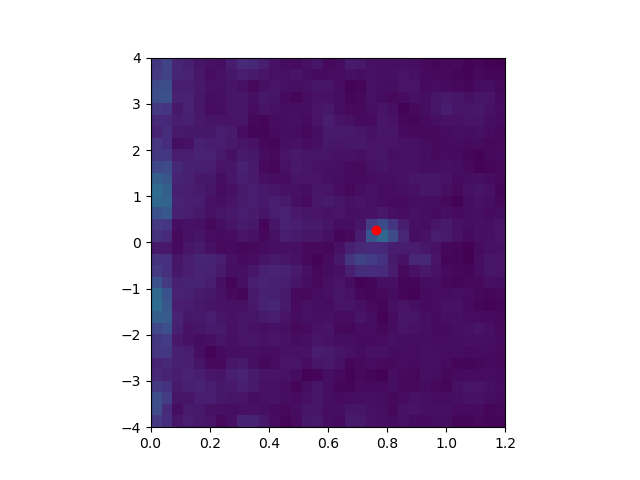

In [23]:
%matplotlib widget
b=create_range_doppler_animation_indices(range_doppler_instances['swipe_up'], indices=np.array([swipe_up_range_ , doppler_swipe_up]));

### Signal Magnitude
- In range-Doppler images, the maximum signal amplitude represents the signal magnitude.


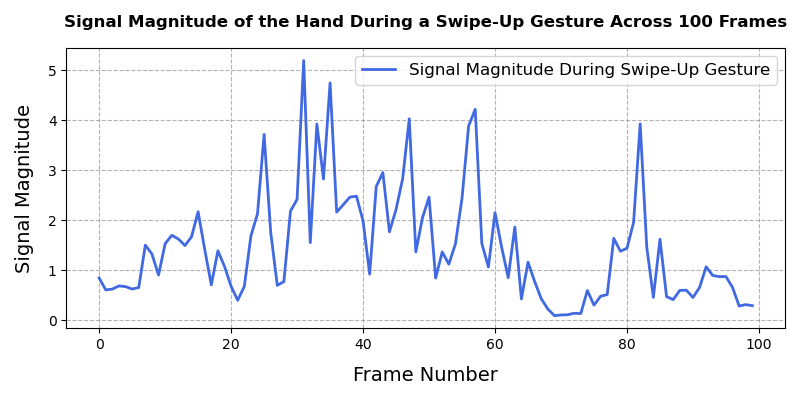

In [24]:
signal_magnitude = range_doppler_instances['swipe_up'][np.arange(100), doppler_bins_swipe_up, range_bins_swipe_up]

# Plot signal magnitudes
plt.figure(figsize=(8, 4))  
plt.plot(
    signal_magnitude, 
    color='royalblue', 
    linewidth=2, 
    label="Signal Magnitude During Swipe-Up Gesture"
)

plt.xlabel("Frame Number", fontsize=14, labelpad=10)
plt.ylabel("Signal Magnitude", fontsize=14, labelpad=10)
plt.title(
    "Signal Magnitude of the Hand During a Swipe-Up Gesture Across 100 Frames", 
    fontsize=12, 
    fontweight='bold', 
    pad=15
)
plt.grid(which='both', linestyle='--', color='gray', alpha=0.6)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()

## Horizontal and Vertical Angle

To calculate angles, we require Doppler-range profiles measured for each antenna.

In [25]:
range_window = windows.blackmanharris(num_samples).reshape(1, num_samples)
doppler_window = windows.blackmanharris(num_chirps).reshape(1, 1, num_chirps, 1)
range_doppler_per_antenna_instances = {}

for name, data in data_instances.items() :
    # Step 1: Remove DC component: subtract mean along the sample axis (axis=-1)
    data_dc_removed = data - np.mean(data, axis=-1, keepdims=True)
    
    # Step 2: Apply windowing (Blackman-Harris) to sample axis
    data_dc_removed_windowed = data_dc_removed * range_window
    
    # Step 3: Apply FFT
    fft_data = np.fft.fft(data_dc_removed_windowed, axis=-1) / np.sum(range_window)  # Normalize by window
    
    # Step 4: Remove the complex mean (mean across the chirps)
    fft_data_complex_mean_removed = fft_data - np.mean(fft_data, axis=2)[..., np.newaxis, :]
    
    # Step 5: Drop the symmetric part of the spectrum
    fft_data_complex_mean_removed = fft_data_complex_mean_removed[...,:num_samples//2 + 1]
    fft_data_complex_mean_removed[:,:,:,1::-1] = 2*fft_data_complex_mean_removed [:,:,:,1::-1]

    # Step 6: Apply windowing (Blackman-Harris) to chirp axis
    fft_data_complex_mean_removed_windowed = fft_data_complex_mean_removed * doppler_window

    # Step 7: Apply FFT on Chirp Axis
    range_doppler = np.fft.fftshift(np.fft.fft(fft_data_complex_mean_removed_windowed, axis=2), axes=2)/np.sum(doppler_window)

    range_doppler_per_antenna_instances[name]= range_doppler

In [26]:
def extract_angles(v1, v2):
    phase = ((np.mod(np.angle(v1) - np.angle(v2) + np.pi, 2*np.pi)) - np.pi )/np.pi
    return np.arcsin(phase)

rx_signals = [range_doppler_per_antenna_instances['swipe_up'][(np.arange(100), i, doppler_bins_swipe_up, range_bins_swipe_up)] for i in range(num_antennas)]
rx_signals = np.vstack(rx_signals)

horizontal_angle = extract_angles(rx_signals[1], rx_signals[2])
vertical_angle = extract_angles(rx_signals[0], rx_signals[2])

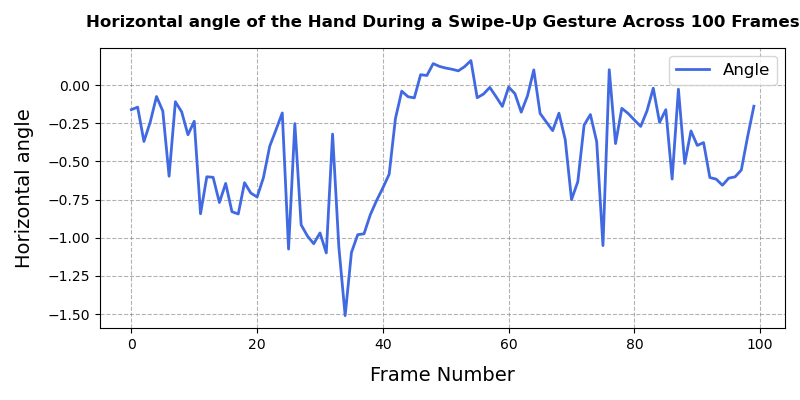

In [27]:
# Plot horizontal angles
plt.figure(figsize=(8, 4))  
plt.plot(
    horizontal_angle,
    color='royalblue', 
    linewidth=2, 
    label="Angle"
)

plt.xlabel("Frame Number", fontsize=14, labelpad=10)
plt.ylabel("Horizontal angle", fontsize=14, labelpad=10)
plt.title(
    "Horizontal angle of the Hand During a Swipe-Up Gesture Across 100 Frames", 
    fontsize=12, 
    fontweight='bold', 
    pad=15
)
plt.grid(which='both', linestyle='--', color='gray', alpha=0.6)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()

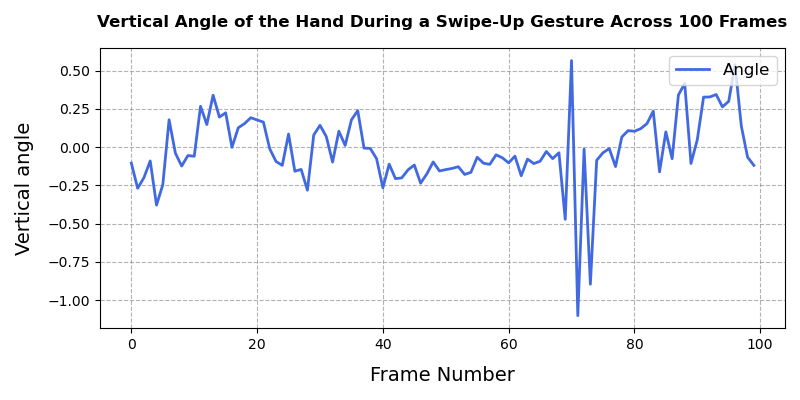

In [28]:
# Plot vertical angles
plt.figure(figsize=(8, 4))  
plt.plot(
    vertical_angle,
    color='royalblue', 
    linewidth=2, 
    label="Angle"
)

plt.xlabel("Frame Number", fontsize=14, labelpad=10)
plt.ylabel("Vertical angle", fontsize=14, labelpad=10)
plt.title(
    "Vertical Angle of the Hand During a Swipe-Up Gesture Across 100 Frames", 
    fontsize=12, 
    fontweight='bold', 
    pad=15
)
plt.grid(which='both', linestyle='--', color='gray', alpha=0.6)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()

## Selecting 10 Frames Where the Actual Gesture Occurred

The reference paper explains that although the entire measurement spans 100 frames (3 seconds), the actual gesture begins when the hand is closest to the radar and lasts for a total of 10 frames. Let us extract the 10 frames where the actual gesture occurred using the scipy find_peaks function.

In [29]:
# Limit the features to the 10 frames following the point of minimum hand-to-radar distance
num_frames = 10

# Identify the frame indices where the hand-to-radar distance reaches a local minimum
idx_frames, _ = find_peaks(-swipe_up_range_, height=-0.5)

# Get the first frame at the minimum distance
first_frame_at_min_distance = idx_frames[0]

frames_swipe_up_instance = np.arange(first_frame_at_min_distance, first_frame_at_min_distance+10, 1)

print("For the selected swipe-up instance, the actual swipe-up action occurs in the following frames:\n", frames_swipe_up_instance)


For the selected swipe-up instance, the actual swipe-up action occurs in the following frames:
 [39 40 41 42 43 44 45 46 47 48]


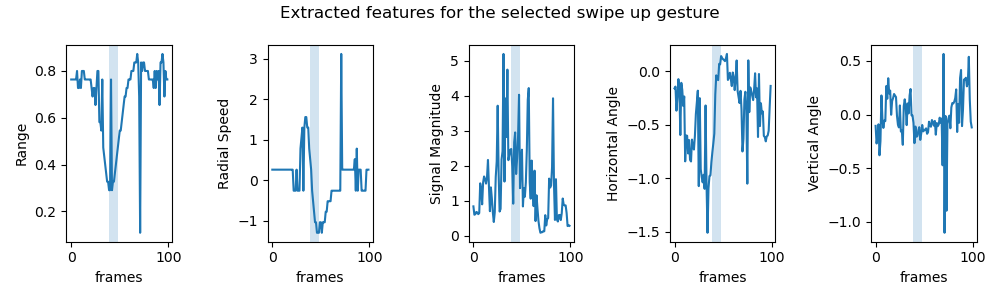

In [30]:
#Visualize all extracted features on the selected swipe up intance by focusing the actual gesture frames
ylabels = ('Range', 'Radial Speed', 'Signal Magnitude', 'Horizontal Angle', 'Vertical Angle')
data_ = [swipe_up_range_, doppler_swipe_up, signal_magnitude,horizontal_angle, vertical_angle]

fig, axes = plt.subplots(1,5, figsize=(10, 3))
for ax, d, label in zip(axes, data_, ylabels):
    ax.plot(d)
    ax.set_ylabel(label)
    ax.set_xlabel("frames")
    ax.fill_between(frames_swipe_up_instance, 0, 1, alpha=0.2, transform=ax.get_xaxis_transform())
plt.suptitle("Extracted features for the selected swipe up gesture")
plt.tight_layout();